# Mechanics of TensorFlow

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/tensorflow/02-tensorflow-mechanics.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

```text
𝗔𝘁𝘁𝗿𝗶𝗯𝘂𝘁𝗶𝗼𝗻: Builds on Chapter 13: Going Deeper - The Mechanics of PyTorch of [SRYLM22] and the Keras API reference.
```

---




## Introduction

In this notebook, we take a deeper dive into lower-level features of TensorFlow. For example, accessing and modifying layer weights and weight gradients, performing automatic differentiation, creating custom layers, and so on. Knowing these tricks would allow us to write more advanced TensorFlow models and write custom functionality for our models and training pipeline.

<br>

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow.keras as kr


from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

import warnings
warnings.simplefilter(action="once")

seed = 0
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

print(tf.config.list_physical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.8.0


## Static graph execution

Computations with eager execution are not as efficient 
as the static graph execution in TensorFlow v1.x, as these can come with pure Python operations. 
TensorFlow v2 provides a tool called **AutoGraph** that can automatically transform Python code into 
TensorFlow's graph code for faster execution. Fortunately for us, TensorFlow provides 
a simple mechanism for compiling a normal Python function to do exactly this: `graph_function = tf.function(eager_function)` or using the `@tf.function` decorator.

### Specifying input signature and static graph tracing 

Note that while TensorFlow graphs, strictly speaking, require static types and shapes, 
`tf.function` readily supports such a dynamic typing capability (through separate static graphs will be created under the hood). For example, let's call this function 
with the following inputs:

In [2]:
def f(x, y, z):
    return x + y + z

f_graph = tf.function(f)
tf.print('Scalar Inputs:', f_graph(1, 2, 3))
tf.print('Rank 1 Inputs:', f_graph([1], [2], [3]))
tf.print('Rank 2 Inputs:', f_graph([[1]], [[2]], [[3]]))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Scalar Inputs: 6
Rank 1 Inputs: [1, 2, 3]
Rank 2 Inputs: [[1], [2], [3]]


2022-07-21 17:58:00.406200: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-21 17:58:00.406437: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-21 17:58:00.429052: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-21 17:58:00.447804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-21 17:58:00.470425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Here, TensorFlow uses a **tracing mechanism** to construct a graph based on the input arguments. For this tracing mechanism, TensorFlow generates a tuple of keys based on the input signatures
given for calling the function. The generated keys are as follows:
* For `tf.Tensor` arguments, the key is based on their shapes and `dtypes`.
* For Python types, such as lists, their `id()` is used to generate cache keys.
* For Python primitive values, the cache keys are based on the input values.

Upon calling such a decorated function, TensorFlow will check whether a graph with
the corresponding key has already been generated. If such a graph does not exist,
TensorFlow will generate a new graph and store the new key. 
If we want to limit the way a function can be called, we can specify its input signature
via a tuple of `tf.TensorSpec` objects when defining the function. For example, let's
take the previous function and modify it so that only rank 1 tensors of
type `tf.int32` are allowed:

In [3]:
def f(x, y, z):
    return x + y + z

f_graph = tf.function(f, input_signature=(
    tf.TensorSpec(shape=[None], dtype=tf.int32),
    tf.TensorSpec(shape=[None], dtype=tf.int32),
    tf.TensorSpec(shape=[None], dtype=tf.int32)
    )
)

tf.print('Rank 1 Inputs:', f_graph([1], [2], [3]))

Rank 1 Inputs: [6]


2022-07-21 17:58:00.525095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


We get an error if we pass a tensor with different shape:

In [4]:
try:
    tf.print('Rank 1 Inputs:', f_graph([[1]], [[2]], [[3]]))
except Exception as e:
    print(e)

Python inputs incompatible with input_signature:
  inputs: (
    [[1]],
    [[2]],
    [[3]])
  input_signature: (
    TensorSpec(shape=(None,), dtype=tf.int32, name=None),
    TensorSpec(shape=(None,), dtype=tf.int32, name=None),
    TensorSpec(shape=(None,), dtype=tf.int32, name=None)).


### Timing static execution runs

In this section, we define a function that takes in an eager function `f` and plots the timings for evaluating `f` eagerly on `x` versus evaluating on its static graph version `tf.function(f)`. As discussed above, the static graph is built after "warming up" once on `x` with its particular shape and type through TensorFlow's tracing mechanism.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from timeit import timeit

def compare_timings(f, x, n):
    # Define functions
    eager_function = f
    graph_function = tf.function(f)

    # Timing
    graph_time = timeit(lambda: graph_function(*x), number=n)
    eager_time = timeit(lambda: eager_function(*x), number=n)
    
    return {
        'graph': graph_time,
        'eager': eager_time
    }

```{margin}
For further info on TF 2.x's tracing mechanism, refer to [this guide](https://www.tensorflow.org/guide/function#tracing).
```

Note that if we fail to persist the static graph, we get the following warning, as well as practically an endless loop. The error message also highlights cases where we make inefficient use of tracing. (Recall the rules above for generating keys for static graphs based on the input.)

> WARNING:tensorflow:6 out of the last 6 calls to <keras.engine.sequential.Sequential object at 0x28575dfa0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop.

Comparing static graph execution with eager execution on a dense network:

In [6]:
from tensorflow.keras.layers import Flatten, Dense

# Model building
model = kr.Sequential()
model.add(Flatten())
model.add(Dense(256, "relu"))
model.add(Dense(256, "relu"))
model.add(Dense(256, "relu"))
model.add(Dense(10, "softmax"))

# Define input + functions
u = tf.random.uniform([100, 28, 28])
mlp_times = compare_timings(model, [u], n=10000);

2022-07-21 17:58:00.888571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Comparing timings with convolution operations:

In [7]:
from tensorflow.keras.layers import Conv2D, AveragePooling2D

# Build model
conv_model = kr.Sequential()
conv_model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
conv_model.add(AveragePooling2D())
conv_model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
conv_model.add(AveragePooling2D())

# Plot timings
u = tf.random.uniform([100, 28, 28, 1])
conv_times = compare_timings(conv_model, [u], n=10000);

2022-07-21 17:58:14.857552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Comparing timings on many extremely small operations:

In [8]:
def small_dense_layer(x):
    w = tf.random.uniform(shape=(3, 1), dtype=tf.float16)
    b = tf.random.uniform(shape=(1,), dtype=tf.float16)
    return tf.add(tf.matmul(x, w), b)

# Plot timings
x = tf.random.uniform(shape=(1, 3), dtype=tf.float16)
small_times = compare_timings(small_dense_layer, [x], n=10000);

2022-07-21 17:58:23.845232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


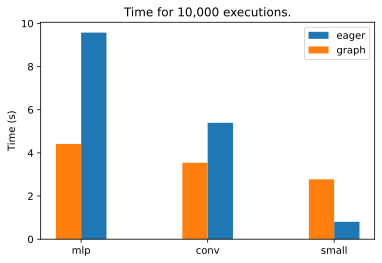

In [9]:
models = ['mlp','conv','small']
eager = [eval(m + '_times')['eager'] for m in models]
graph = [eval(m + '_times')['graph'] for m in models]
x = np.arange(len(models))


plt.bar(x + 0.1, eager, width=0.2, label='eager')
plt.bar(x - 0.1, graph, width=0.2, label='graph')
plt.xticks(x, models)
plt.ylabel("Time (s)")
plt.title("Time for 10,000 executions.")
plt.legend();

The above results show that graph execution can be faster can be faster than eager code, especially for graphs with expensive operations. But for graphs with few expensive operations (like convolutions), you may not see much speedup or even worse with many cheap operations. Perhaps because there is overhead in the tracing mechanism for static graphs and alternating between TensorFlow and Python abstractions.

## TensorFlow `Variable`

A `Variable` is a special `Tensor` object
that allows us to store and update the parameters of our models during training.
This can be created by just calling the `tf.Variable` class on user-specified
initial values. 

In [10]:
a = tf.Variable(initial_value=3.0, name='var_a') # float32 by default.
b = tf.Variable(initial_value=[1, 2, 3], name='var_b')
c = tf.Variable(initial_value=['c'], dtype=tf.string)

print(a)
print(b)
print(c)

<tf.Variable 'var_a:0' shape=() dtype=float32, numpy=3.0>
<tf.Variable 'var_b:0' shape=(3,) dtype=int32, numpy=array([1, 2, 3], dtype=int32)>
<tf.Variable 'Variable:0' shape=(1,) dtype=string, numpy=array([b'c'], dtype=object)>


Note that initial value is required. TF variables have an attribute called `trainable`, which by default is set to `True`. Higher-level APIs such as Keras will use this attribute to manage the trainable variables and non-trainable ones. You can define a non-trainable `Variable` as follows:

In [11]:
w = tf.Variable(3.0, trainable=False)
print(w.trainable)

False


### Modifying the value of a variable

The values of a `Variable` can be efficiently modified by running some operations
such as `.assign()`, `.assign_add()` and related methods. When the `read_value` argument is set to `True` (default), these operations will automatically return the new values after updating the current values of the `Variable`.

In [12]:
w.assign(0.0, read_value=True)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.0>

Setting the `read_value` to `False` will suppress the automatic return of the updated value but the `Variable` will still be updated in place.

In [13]:
tf.print(w.assign_add(-1.0, read_value=False))
tf.print(w)

None
-1


### Initializing a TensorFlow module

In practice, we usually define and initialize a `Variable` inside a `tf.Module` class. In the example below, we define two variables one trainable one and another non-trainable. These variables can be accessed using the `.variables` and `.trainable_variables` attribute of TF modules.

In [14]:
class MyModule(tf.Module):
    def __init__(self):
        init = kr.initializers.GlorotNormal()
        self.w1 = tf.Variable(init(shape=(2, 3)), trainable=True)
        self.w2 = tf.Variable(init(shape=(1, 2)), trainable=False)


m = MyModule()
print("All module variables:", [v.shape for v in m.variables])
print("Trainable variables:", [v.shape for v in m.trainable_variables])

All module variables: [TensorShape([2, 3]), TensorShape([1, 2])]
Trainable variables: [TensorShape([2, 3])]


2022-07-21 17:58:27.853042: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


### Variables and TF functions

Note that if we define a TF variable inside a pure Python function, then this variable will be initialized every time the function is called. Since the static graph will try to reuse the variable based on tracing and graph creation, TF prevents variable initialization inside a decorated TF function. 

One way to avoid this problem is to define the `Variable` outside of the decorated
function and use it inside the function &mdash; this is not recommended with a global scope. Instead, you should define a class to manage this dependency in a separate namespace.

In [15]:
@tf.function
def f(x):
    w = tf.Variable([3.0])
    return x * w

# Testing
try:
    f(1.0)
except Exception as e:
    print(e)

in user code:

    File "/var/folders/jq/9vsvd9252_349lsng_5gc_jw0000gn/T/ipykernel_11123/2632006634.py", line 3, in f  *
        w = tf.Variable([3.0])

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.



Instead do:

In [16]:
# Declare variable outside function <- make sure to not pollute the global namespace
w = tf.Variable([3.0])

@tf.function
def f(x):
    return x * w

# Testing
try:
    tf.print(f(1.0))
except Exception as e:
    print(e)

[3]


2022-07-21 17:58:28.021404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Automatic Differentiation

TensorFlow supports automatic differentiation which implements symbolic differentiation for each operation defined in the language. For nested functions, TF provides a context called `GradientTape` for calculating gradients of these computed tensors with respect to its dependent nodes in the computation graph. This allows TensorFlow needs to remember what operations happen in what order during the forward pass. This list of operations is traversed backwards during [backward pass](https://particle1331.github.io/inefficient-networks/notebooks/fundamentals/backpropagation.html) to compute the weight gradients.

### Gradients of the loss with respect to weights

In order to compute these gradients, we have to "record" the computations via `tf.GradientTape`. Note that the shape of `tape.gradient(loss, w)` is the same as that of `w`.  

In [17]:
# scope outside tf.GradientTape
w = tf.Variable(1.0)
b = tf.Variable(0.5)

# data
x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])

with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

grad = tape.gradient(loss, w)
tf.print("∂(loss)/∂w =", grad)
tf.print(2 * (y - w*x - b) * (-x)) # symbolic

∂(loss)/∂w = -0.559999764
[-0.559999764]


#### Higher-order gradients

It turns out that TF supports stacking gradient tapes which allow us to compute **second derivatives**:

In [18]:
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        z = tf.add(tf.multiply(w, x), b)
        loss = tf.reduce_sum(tf.square(y - z))
    grad_w = inner_tape.gradient(loss, w)
grad_wb = outer_tape.gradient(grad_w, b)

tf.print("∂²(loss)/∂w∂b =", grad_wb)
tf.print(2 * (-1) * (-x)) # symbolic

∂²(loss)/∂w∂b = 2.8
[2.8]


### Gradients with respect to nontrainable parameters

`GradientTape` automatically supports the gradients for trainable variables.
For non-trainable variables[^refadversarial] and other `Tensor` objects, we need to add
`tape.watch()` to monitor those as well.

[^refadversarial]: Computing gradients of the loss with respect to the input
example is used for generating adversarial examples.

In [19]:
with tf.GradientTape() as tape:
    tape.watch(x) # <-
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

grad = tape.gradient(loss, x)
tf.print("∂(loss)/∂x =", grad)
tf.print(2 * (y - w*x - b) * (-w)) # check symbolic

∂(loss)/∂x = [-0.399999857]
[-0.399999857]


### Persisting the gradient tape

Note that the tape will keep the resources only for a single gradient computation by default. So
after calling `tape.gradient()` once, the resources will be released and the tape will
be cleared. If we want to compute more than one gradient, we need to persist it (less memory efficient).

In [20]:
with tf.GradientTape() as tape:
    tape.watch(x)
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

try:
    tf.print("∂(loss)/∂w =", tape.gradient(loss, w))
    tf.print("∂(loss)/∂x =", tape.gradient(loss, x))
except Exception as e:
    print(e)

∂(loss)/∂w = -0.559999764
A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [21]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

tf.print("∂(loss)/∂w =", tape.gradient(loss, w))
tf.print("∂(loss)/∂x =", tape.gradient(loss, x)) # grad_x has same shape as x

∂(loss)/∂w = -0.559999764
∂(loss)/∂x = [-0.399999857]


### Applying optimizer step to update model parameters

During SGD, we are computing gradients of a loss term with respect to model weights, which we use to update the weights according to some rule defined by an optimization algorithm. For Keras optimizers, we can do this by  using `.apply_gradients`:

In [22]:
grad_w = tape.gradient(loss, w)
grad_b = tape.gradient(loss, b)
lr = 0.1
tf.print('w =', w)
tf.print('b =', b)
tf.print('λ =', lr)
tf.print('grad_[w, b] =', [grad_w, grad_b])

# Define keras optimizer; apply optimizer step
optimizer = kr.optimizers.SGD(learning_rate=lr)
optimizer.apply_gradients(zip([grad_w, grad_b], [w, b]))

# Print updates
tf.print()
tf.print('w - λ·∂(loss)/∂w ≟', w)
tf.print('b - λ·∂(loss)/∂b ≟', b)

w = 1
b = 0.5
λ = 0.1
grad_[w, b] = [-0.559999764, -0.399999857]

w - λ·∂(loss)/∂w ≟ 1.056
b - λ·∂(loss)/∂b ≟ 0.539999962


Checks out nicely.

## Keras API

Keras provides a user-friendly and
modular programming interface that allows easy prototyping and the building of
complex models in just a few lines of code which
in TensorFlow 2, has become the primary and recommended approach
for implementing models via the Keras library.  This has the advantage that it supports TensorFlow specific functionalities, such as [dataset pipelines using `tf.data`](https://particle1331.github.io/inefficient-networks/notebooks/tensorflow/01-tensorflow-nn.html#).

### Stacking layers with `Sequential`

For stacking layers that perform sequential transforms on input data, we typically use `kr.Sequential()`. Such a model has an `add()` method to add individual Keras layers. 
Alternatively, we can instantiate such a network using `kr.Sequential(layers)` with a list `layers` of feedforward Keras layers.

In [23]:
from tensorflow.keras.layers import Dense

# Create model
model = kr.Sequential()
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='relu'))

# Build model
model.build(input_shape=(None, 4))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                80        
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


Once variables (or model parameters) are created, we can access both
trainable and non-trainable variables as follows:

In [24]:
for v in model.variables:
    print(f'{v.name:20s} {str(v.trainable):7} {v.shape}')

dense_4/kernel:0     True    (4, 16)
dense_4/bias:0       True    (16,)
dense_5/kernel:0     True    (16, 32)
dense_5/bias:0       True    (32,)
dense_6/kernel:0     True    (32, 1)
dense_6/bias:0       True    (1,)


### Compiling Keras models

Compiling prepares the model for training via `model.fit()`. Here we can specify a loss function, the optimization algorithm, as well as a list of metrics that will be used to evaluate the model.

```python
model.compile(
    optimizer=kr.optimizers.SGD(learning_rate=0.001),
    loss=kr.losses.BinaryCrossentropy(),
    metrics=[
        kr.metrics.Accuracy(),
        kr.metrics.Precision(),
        kr.metrics.Recall()
    ]
)
```

#### API for cross entropy

Note that cross entropy is a probabilistic loss. And we expect network outputs to be related to class-probabilities. Since softmax activation has worked quite well and is widely used for classification tasks, instead of computing cross entropy directly from probability vectors, some implementations expect **logits** (i.e. softmax preactivation) as inputs to the cross entropy loss function. So you always have to check the docs. 

<br>

**Probabilities.** The default behavior in Keras is `from_logits=False` where the expected network output are class-probabilities in `[0, 1]` over the number of classes that sum to `1.0`. This can come from a `softmax` activation, though any output is allowed as long as the outputs are class distributions. Here the loss function computes `-log q[k*]` where `q` is the output of the network and `k*` is the index of the true class. Predictions of class label can be obtained using `tf.argmax(q)`. 

```python
model = kr.Sequential()
model.add(kr.layers.Dense(512, 'relu'))
model.add(kr.layers.Dense(10, 'softmax')) # class-probabilities

model.compile(
    metrics=['accuracy'],
    optimizer='adam',
    loss=kr.losses.SparseCategoricalCrossentropy()
)
```

<br>

**Logits.** Using logits instead of probabilities can be implemented in Keras by setting `from_logits=True` in the cross entropy loss function. In this case, it will be expected that outputs of the network are from a dense linear layer. To find class-probabilities for a test input `x`, we use `tf.nn.softmax(model(x))`. Note that we can still use `tf.argmax(s)` on network outputs `s` to predict class labels since softmax is monotonic. Finally, the loss function computes the cross entropy `-log q[k*]` with `q=softmax(s)` for each output-label pair `(s, k*)`. This has the numerically stable form: `-s[k*] + log(sum(exp(s)))`.

```python
model = kr.Sequential()
model.add(kr.layers.Dense(512, 'relu'))
model.add(kr.layers.Dense(10)) # logits

model.compile(
    metrics=['accuracy'],
    optimizer='adam',
    loss=kr.losses.SparseCategoricalCrossentropy(from_logits=True)
)
```


<br>

```{figure} https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch15/images/15_11.png
---
name: loss-logits-keras
width: 45em
---

Keras API for loss functions. {cite}`RaschkaMirjalili2019` (Chapter 15)
```

### Solving the XOR problem

**Dataset.** The XOR is the smallest dataset that is not linearly separable (also the most historically interesting relative to its size {cite}`Minsky1969`). Our version of the XOR dataset is generated by adding Gaussian noise to points `(-1, -1)`, `(-1, 1)`, `(1, -1)` and `(1, 1)`. Points generated from `(1, 1)` and `(-1, -1)` will be labeled `1` otherwise `0`. A dataset of size 200 points will be generated with half used for validation.

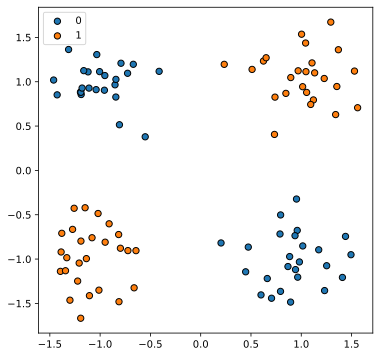

In [25]:
# Create dataset
X = []
Y = []
for p in [(1, 1), (-1, -1), (-1, 1), (1, -1)]:
    x = np.array(p) + np.random.normal(0, 0.3, size=(50, 2)) 
    y = int(p[0] * p[1] > 0) * np.ones(50)
    X.append(x)
    Y.append(y)

X = np.concatenate(X)
Y = np.concatenate(Y)

# Train-test split
indices = list(range(200))
np.random.shuffle(indices)
valid = indices[:100]
train = indices[100:]
X_valid, y_valid = X[valid, :], Y[valid]
X_train, y_train = X[train, :], Y[train]

# Visualize dataset
fig = plt.figure(figsize=(6, 6))
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], s=40, edgecolor='black', label=0)
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], s=40, edgecolor='black', label=1)
plt.legend();

<br>

**Network architecture.** As a general rule of thumb, the more layers we have,
and the more neurons we have in each layer, the larger the capacity of the model
will be. While having more parameters means the network can fit more complex functions, larger models are usually harder to train (and are prone to overfitting). Model capacity can be increased by increasing:

* **Width.** 
The universal approximation theorem states that a feedforward NN with a single hidden 
layer and a sufficiently large number of hidden units can approximate any continuous function
to arbitrary accuracy. But this doesn't apply to the current task which is a classification problem. Indeed, we need a network of at least depth 2 to properly classify the dataset.
<br><br>

* **Depth.** The advantage of making a network deeper rather than wider is 
that fewer parameters are required to achieve a comparable model capacity. 
However, a downside of deep (versus wide) models is that deep models are prone
to vanishing and exploding gradients, which make them harder to train.
<br><br>

As mentioned, from the geometry of the dataset, we have to use a network that has at least depth 2, so its not linear. However, since the dataset is small, we want the network to be not too wide (and not too deep), so the model does not overfit on the dataset.

In [26]:
model = kr.Sequential()
model.add(kr.layers.Dense(units=4, activation='tanh'))
model.add(kr.layers.Dense(units=1, activation='sigmoid'))

Keras provides `.summary()` which prints a summary of the network architecture.
Since the number of parameters for the input layer depend on input size , we 
need to specify the dimension of the input. This is done by calling `model.build`
on the expected input shape:

In [27]:
model.build(input_shape=(None, 2))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 4)                 12        
                                                                 
 dense_8 (Dense)             (None, 1)                 5         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


`None` is used as a placeholder for the first dimension of the input to make room for arbitrary batch sizes. Alternatively, we could have set `input_shape` in the input layer so we can skip model build. 

<br>

**Model training.** Writing the `train()` function is boilerplate code.
Since the training loop can be complex, developing this each time can
potentially be a source of bugs, not to mention time-consuming. 
TensorFlow Keras API provides a convenient [`.fit()`](https://keras.io/api/models/model_training_apis/#fit-method) method that can be called 
on a compiled model. Observe that this function accepts numpy array as training and validation datasets. In this case, we have to pass batch size which are sampled randomly by default. (Recall that these parameters have to be set if we are to pass `Dataset` objects.)

In [28]:
model.compile(
    optimizer=kr.optimizers.SGD(),
    loss=kr.losses.BinaryCrossentropy(),
    metrics=[kr.metrics.BinaryAccuracy()]
)

hist = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=200,
    batch_size=2, verbose=0
)

2022-07-21 17:58:29.013676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-21 17:58:29.288452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


```{margin}
Refer to the [Keras developer guides](https://keras.io/guides/), if more precise control of the details of the training process is needed.
```

The `fit` method handles the low-level details (regularization, callbacks, metrics, etc.) of training consistently across different implementations. Moreover, this is designed to be performant by exploiting static graph computation. Hence, it is recommended to use `fit` for most use-cases (as well as other built-ins such as `evaluate` and `predict` for inference).

<br>

**Results.** The `fit()` method returns a dictionary containing data on how the model trained. We will use this to generate visualizations of the training process. To further evaluate the model, we also look at its decision boundaries. 

In [29]:
hist.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

4/4 [==============================] - 0s 8ms/step - loss: 0.0346 - binary_accuracy: 1.0000


2022-07-21 17:59:14.532880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-21 17:59:14.700818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


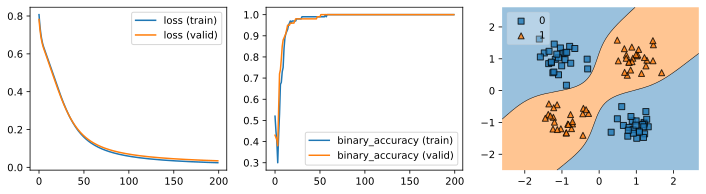

In [30]:
from mlxtend.plotting import plot_decision_regions

def plot_training_history(hist, metric_name):
    _, ax = plt.subplots(1, 3, figsize=(12, 3))

    ax[0].plot(range(200), hist.history['loss'], label='loss (train)')
    ax[0].plot(range(200), hist.history['val_loss'], label='loss (valid)')
    ax[0].legend()

    ax[1].plot(range(200), hist.history[metric_name], label=f'{metric_name} (train)')
    ax[1].plot(range(200), hist.history[f'val_{metric_name}'], label=f'{metric_name} (valid)')
    ax[1].legend();

    ax[2] = plot_decision_regions(X=X_valid, y=y_valid.astype(np.int_), clf=model, legend=2)
    return ax

model.evaluate(X_valid, y_valid)
plot_training_history(hist, 'binary_accuracy');

To see model confidence, we can look at the prediction probability at each point in $[-1, 1]^2.$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


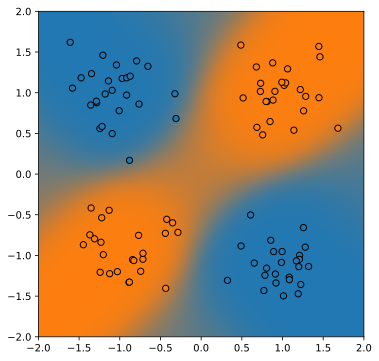

In [31]:
from matplotlib.colors import to_rgba

# Plot valid set points
def plot_decision_gradient(model):
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X_valid[y_valid==0, 0], X_valid[y_valid==0, 1], s=40, edgecolor='black', label=0)
    plt.scatter(X_valid[y_valid==1, 0], X_valid[y_valid==1, 1], s=40, edgecolor='black', label=1)

    # Plot decision gradient
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = np.arange(-2, 2, step=0.01)
    x2 = np.arange(-2, 2, step=0.01)

    xx1, xx2 = np.meshgrid(x1, x2)
    model_inputs = np.stack([xx1, xx2], axis=-1)
    preds = model(model_inputs.reshape(-1, 2)).numpy().reshape(400, 400, 1)
    output_image = (1 - preds) * c0 + preds * c1 # blending
    plt.imshow(output_image, origin='lower', extent=(-2, 2, -2, 2));

# Plotting
plot_decision_gradient(model);

### Functional API

Recall that using `Sequential` only allows for a sequence of transformations. This is too restrictive for other architectures. Keras' so-called functional API comes in handy for more complex transformations such as **residual connections**. Observe that the model build adds a new layer called `tf.__operators__.add` under the hood.

In [32]:
# Specify input and output
x = kr.Input(shape=(2,))
f = Dense(units=2, input_shape=(2,), activation='relu')(x)
out = Dense(units=1, activation='sigmoid')(x + f)

# Build model
model = kr.Model(inputs=x, outputs=out)
model.summary() # compile, fit, etc. also works 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 2)            6           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 2)           0           ['input_1[0][0]',                
 da)                                                              'dense_9[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 1)            3           ['tf.__operators__.add[0][0]'

### Model class

An alternative way to build complex models is by subclassing `kr.Model`. A model derived from `kr.Model` inherits methods such as `build()`, `compile()`, and `fit()`.

In [33]:
class MyModel(kr.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(units=4, activation='tanh')
        self.dense2 = Dense(units=1, activation='sigmoid')

    def call(self, x):
        h1 = self.dense1(x)
        out = self.dense2(h1)
        return out


# Build model and model summary
model = MyModel()
model.build(input_shape=(None, 2))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            multiple                  12        
                                                                 
 dense_12 (Dense)            multiple                  5         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


### Custom Keras layers

Notice that we've been using Keras layers in defining our models. In cases where we want to define a new layer that is not already supported by Keras, or customizing an existing layer,
we can do this by extending the `Layer` base class. In the custom class, we have to define `__init__()` and `call()`. The `build()` method handles delayed variable initialization. Finally, we define a `get_config()` which can be useful for model serialization (saving and loading). 

<br>

**Implementation.** To illustrate the concept of implementing custom layers, let's consider a simple
example. We define a new linear layer that computes $(\mathbf x + \boldsymbol{\varepsilon}) \cdot \mathbf w + \boldsymbol {b}$
where $\boldsymbol\varepsilon$ refers to a random variable as noise, then passes the result to a ReLU nonlinearity. We assume that $\mathbf x$ is a rank 2 tensor with shape `(B, d)` where `B` is the batch size and `d` is the size of the (flattened) inputs. 

In [34]:
class NoisyLinear(kr.layers.Layer):
    def __init__(self, output_dim, noise_stddev=0.1, **kwargs):
        self.output_dim = output_dim
        self.noise_stddev = noise_stddev
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.w = self.add_weight(
            name='weights', 
            shape=(input_shape[1], self.output_dim),
            initializer='random_normal',
            trainable=True
        )

        self.b = self.add_weight(
            name='bias',
            shape=(self.output_dim,),
            initializer='zeros',
            trainable=True
        )
    
    def call(self, x, training=False):
        if training:
            noise = tf.random.normal(
                shape=x.shape, 
                mean=0.0, 
                stddev=self.noise_stddev
            )
        else:
            noise = tf.zeros_like(x)
        
        z = tf.matmul(x + noise, self.w) + self.b
        return kr.activations.relu(z)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "noise_stddev": self.noise_stddev
        })
        return config

```{margin}
This is analogous to `model.train()` and `model.eval()` in PyTorch. Though, I think having an explicit variable to handle this is nice.
```

Notice that in the `call()` method, we have used an
additional argument, `training=False`. This distinguishes whether a model or layer
is used at training or at inference time. This is automatically set in Keras to `True` when using `.fit` and to `False` when using `.predict`. 

The `training` flag is implemented because there are operations that behave differently in
training and prediction modes such as dropout and batch normalization. In the case of `NoisyLayer`, noise is only added during training; no noise is added at inference. 

In [35]:
noisy_layer = NoisyLinear(output_dim=1)
noisy_layer.build(input_shape=(None, 1))

tf.print(noisy_layer.w)
tf.print(noisy_layer.b)

[[-0.0243417677]]
[0]


Let's look at the noise distribution.

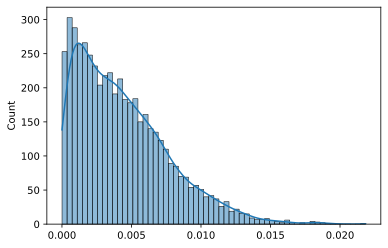

In [36]:
import seaborn as sns

out = noisy_layer(tf.zeros([10000, 1]), training=True)
sns.histplot(out[out > 0].numpy().reshape(-1), bins=60, kde=True);

Testing the `.config` method.

In [63]:
# Re-building from config:
config = noisy_layer.get_config()
new_layer = NoisyLinear.from_config(config)
print(config)

{'name': 'noisy_linear', 'trainable': True, 'dtype': 'float32', 'output_dim': 1, 'noise_stddev': 0.1}


Testing call outside training if noise is zero:

In [64]:
# Zero noise?
tf.math.reduce_sum(noisy_layer(tf.zeros(shape=(100, 1)))).numpy()

0.0

<br>

**Remodelling.** In this section, we will add `NoisyLinear` to our previous model for XOR. Note that noise should be scaled depending on the magnitude of the input. In our case, the input features vary between $-1$ to $1,$ so we set $\sigma = 0.3$ in the noisy linear for it to have considerable effect.

In [39]:
model = kr.Sequential()
model.add(kr.layers.Dense(units=4, activation='tanh'))
model.add(NoisyLinear(output_dim=4, noise_stddev=0.3))
model.add(kr.layers.Dense(units=1, activation='sigmoid'))

model.build(input_shape=(None, 2))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 4)                 12        
                                                                 
 noisy_linear_1 (NoisyLinear  (None, 4)                20        
 )                                                               
                                                                 
 dense_14 (Dense)            (None, 1)                 5         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(
    optimizer=kr.optimizers.SGD(),
    loss=kr.losses.BinaryCrossentropy(from_logits=False),
    metrics=[kr.metrics.BinaryAccuracy()]
)

hist = model.fit(
    X_train, y_train, # fit accepts numpy arrays
    validation_data=(X_valid, y_valid),
    epochs=200,
    batch_size=2, verbose=0
)

2022-07-21 17:59:23.844577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-21 17:59:24.113561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-07-21 18:00:13.292938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


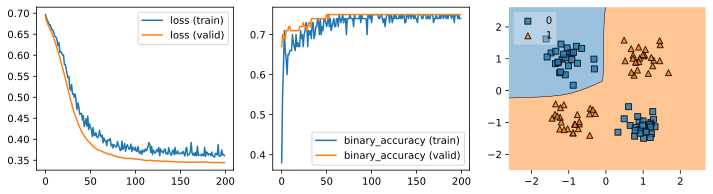

In [41]:
plot_training_history(hist, 'binary_accuracy');

Notice that the training curve is noisier than before since we added a large amount of noise. On the other hand, the validation curves are not noisy at all. This shows Keras automatically sets `training` to `False` during evaluation. Also note that while the validation performance is perfect, it seems to generalize worse since the decision boundaries are too sharp.

### Saving and loading models

We can save and load a model for checkpointing as follows:

In [42]:
model.save('model.h5', 
    overwrite=True, 
    include_optimizer=True, # also save state of optimizer 
    save_format='h5'
)

**Testing load.** Note that custom layers need to be taken particular care of.

In [43]:
model_load = kr.models.load_model(
    'model.h5', 
    custom_objects={'NoisyLinear': NoisyLinear}
)

model_load.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 4)                 12        
                                                                 
 noisy_linear_1 (NoisyLinear  (None, 4)                20        
 )                                                               
                                                                 
 dense_14 (Dense)            (None, 1)                 5         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


We can also save the network architecture as a JSON file.

In [44]:
import json

json_object = json.loads(model_load.to_json())
print(json.dumps(json_object, indent=2))

{
  "class_name": "Sequential",
  "config": {
    "name": "sequential_4",
    "layers": [
      {
        "class_name": "InputLayer",
        "config": {
          "batch_input_shape": [
            null,
            2
          ],
          "dtype": "float32",
          "sparse": false,
          "ragged": false,
          "name": "dense_13_input"
        }
      },
      {
        "class_name": "Dense",
        "config": {
          "name": "dense_13",
          "trainable": true,
          "dtype": "float32",
          "units": 4,
          "activation": "tanh",
          "use_bias": true,
          "kernel_initializer": {
            "class_name": "GlorotUniform",
            "config": {
              "seed": null
            }
          },
          "bias_initializer": {
            "class_name": "Zeros",
            "config": {}
          },
          "kernel_regularizer": null,
          "bias_regularizer": null,
          "activity_regularizer": null,
          "kernel_constrai

## Appendix: Keras deep dive

### Metrics

Metrics are used to evaluate model predictions.
Recall that we specify metrics when compiling models with `model.compile()` where we can pass a list of metrics. Metric values are displayed during `fit()` and logged to the `History` object returned by `fit()`. They are also returned by `model.evaluate()`.

In [45]:
model = kr.Sequential()
model.add(Dense(units=4, input_shape=(2,), activation='tanh'))
model.add(Dense(units=1)) # logits, i.e. pre-sigmoid

model.compile(
    optimizer='adam',
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        kr.metrics.Accuracy(),
        kr.metrics.AUC(from_logits=True)
    ]
)

hist = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=60,
    batch_size=2, verbose=0
)


2022-07-21 18:00:22.354141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-21 18:00:22.897727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [46]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

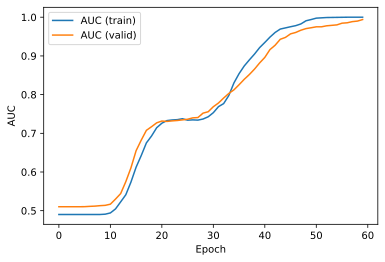

In [47]:
plt.plot(hist.history['auc'], label="AUC (train)")
plt.plot(hist.history['val_auc'], label="AUC (valid)")
plt.ylabel("AUC")
plt.xlabel("Epoch")
plt.legend();

#### Standalone usage

Keras metrics are stateful. To use them as a standalone, we have to update the state first. Below, we have a 2 batches, each of size 4, and we want to compute the accuracy.

In [48]:
m = kr.metrics.Accuracy()
m.update_state([0, 1, 1, 1], [1, 1, 1, 1]) # (y_true, y_pred). 3/4
print('Intermediate result:', float(m.result()))

m.update_state([1, 1, 1, 1], [1, 1, 1, 1]) # Update with 4/4 -> 7/8
print('Intermediate result:', float(m.result()))

Intermediate result: 0.75
Intermediate result: 0.875


#### Custom metrics

From the previous section, we saw how metrics in Keras are computed. Hence, the following API for creating custom metrics should be natural. First, we initialize weights for tracking the total sum of squared error `mse_sum`, and the total number of samples `total_samples` inside `__init__`. The return value (scalar) of the metric is defined in the `result` method. In our case, this is `sqrt(mse_sum / total_samples)`. 

As these variables are stateful, the API makes us define `update_state` to make updates on the state. Finally, we define `reset_state` where we simply assign zero to the weights. Note that states are persisted only between batches (within an epoch or single evaluation).

In [49]:
class RootMeanSquaredError(kr.metrics.Metric):
    """Custom metric for computing RMSE."""

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(
            name="mse_sum", 
            initializer="zeros"
        )
        self.total_samples = self.add_weight(
            name="total_samples", 
            initializer="zeros", 
            dtype="int32"
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)

        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)


    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

Let's test this:

In [50]:
rmse = RootMeanSquaredError()
y_true = tf.constant(np.random.randn(32), dtype=tf.float32)
y_pred = tf.constant(np.random.randn(32), dtype=tf.float32)

rmse.update_state(y_true[:16], y_pred[:16])
print('Intermediate RMSE:', float(rmse.result()))

rmse.update_state(y_true[16:], y_pred[16:])
print('Intermediate RMSE:', float(rmse.result()))

Intermediate RMSE: 1.4261493682861328
Intermediate RMSE: 1.4200266599655151


In [51]:
print("Overall RMSE:", tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred)) / len(y_true)).numpy())

Overall RMSE: 1.4200268


### Callbacks API

A **callback** is an object that can perform actions or view internal states at various stages of training: at the start or end of an epoch, before or after a single batch, etc. The following callbacks are commonly used: 
* `ModelCheckpoint` to save the best model
* `TensorBoard` for monitoring 
* `EarlyStopping` to prevent overfitting 
* `LearningRateScheduler` and `ReduceLROnPlateau` for updating the learning rate
* and `CSVLogger` to stream epoch results to a CSV file.

As an action is defined on [every phase of training, testing, and prediction](https://keras.io/guides/writing_your_own_callbacks/#an-overview-of-callback-methods), the API simply allows us to a list of callbacks in the keyword argument `callbacks` to the `fit()`, `evaluate()`, and `predict()` methods of Keras models, respectively. The callback will execute the specific action based on the current phase. Following this API, [writing custom callbacks](https://keras.io/guides/writing_your_own_callbacks) is also straightforward. 

### Custom training loop

The following `train_step` function encapsulates a single step of SGD. For demonstration, we will train a model for classifiying [Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist) images. First, we will fetch the dataset. Then, we define a simple MLP with Dropout.

In [52]:
import time
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense


def transform_image(image):
    return tf.reshape(tf.image.per_image_standardization(image), (-1,))

def get_fmnist_model():
    model = kr.Sequential()
    model.add(Dense(256, "relu", input_shape=(784,)))
    model.add(Dense(256, "relu"))
    model.add(Dense(256, "relu"))
    model.add(Dense(10))
    return model


FMNIST, FMNIST_info = tfds.load(
    "fashion_mnist", 
    data_dir="./data", 
    with_info=True, 
    shuffle_files=False
)

train_ds, valid_ds = FMNIST["train"], FMNIST["test"]
f = lambda x: (transform_image(x["image"]), x["label"])
train_ds = train_ds.map(f)
valid_ds = valid_ds.map(f)
print(len(train_ds), len(valid_ds))

60000 10000


#### Train and eval steps

Below we instantiate our loss functions, metrics, and optimizer outside of the `train_step` and `eval_step` functions. These are stateless except for the metrics. But the states of the metrics are reset at each epoch, so essentially can also be considered stateless, in the context of training runs. 

In [53]:
loss_fn = kr.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = kr.optimizers.SGD()
metrics = [kr.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = kr.metrics.Mean(name='loss')


def train_step(input, target, model):
    """Single weight update of neural network in TRAIN mode."""

    # Track gradients -> backprop -> update weights
    with tf.GradientTape() as tape:
        output = model(input, training=True) # !
        loss = loss_fn(target, output)
    
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Log metrics
    logs = {}
    for metric in metrics:
        metric.update_state(target, output)
        logs[metric.name] = metric.result()

    # Log moving average of train loss
    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    return logs


def eval_step(input, target, model):
    """Evaluation of neural network."""

    # Make forward pass
    output = model(input, training=False) # !
    loss = loss_fn(target, output)

    # Make logs
    logs = {}
    for metric in metrics:
        metric.update_state(target, output)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

<br>

**Training loop**. We want to persist the state of metrics across batches, but not across epochs. Thus, we define a function to reset the metrics at each new epoch. Note that the algorithm for training is, in essence, what is being done [inside the Keras `fit` method](https://github.com/keras-team/keras/blob/c277bcb0417f5c682f945627bd9d78a5763c38cf/keras/engine/training.py#L1396).

In [54]:
def reset_metrics():
    for metric in metrics + [loss_tracking_metric]:
        metric.reset_state()


def run_training(num_epochs, model, train_step, eval_step, verbose=0):
    """Custom trainer for Keras models."""

    start_time = time.time()
    valid_input, valid_target = next(iter(valid_ds.batch(10000)))
    train_dataset = train_ds.shuffle(10000).batch(32).prefetch(100)
        
    for epoch in range(num_epochs):
        reset_metrics()
        
        # Log each weight update
        for input_batch, target_batch in train_dataset:
            logs = train_step(input_batch, target_batch, model=model)
        
        # Evaluate once after each epoch
        valid_logs = eval_step(valid_input, valid_target, model=model)

        # Note that train logs are overwritten at each step; print last   
        if verbose:  
            print(f"Results at the end of epoch {epoch}")
            for key, value in logs.items():
                print(f"  {key}: {value:.4f}")
            for key, value in valid_logs.items():
                print(f"  {key}: {value:.4f}")
            print()
    
    return time.time() - start_time

Let's time training over three epochs:

In [55]:
timings = {}
tf.random.set_seed(0)
timings['custom_eager'] = run_training(
    num_epochs=3, 
    model=get_fmnist_model(),
    verbose=1,
    train_step=train_step,
    eval_step=eval_step
)

Results at the end of epoch 0
  sparse_categorical_accuracy: 0.8137
  loss: 0.5237
  val_sparse_categorical_accuracy: 0.8166
  val_loss: 0.5237

Results at the end of epoch 1
  sparse_categorical_accuracy: 0.8651
  loss: 0.3736
  val_sparse_categorical_accuracy: 0.8641
  val_loss: 0.3736

Results at the end of epoch 2
  sparse_categorical_accuracy: 0.8771
  loss: 0.3352
  val_sparse_categorical_accuracy: 0.8747
  val_loss: 0.3352



#### Static graph execution

Here we will compile the `train_step` and `test_step` functions to static graphs with `tf.function`. We will test whether this has significant speed up in training time over the eager version. Note that we run this once. This is so that the times obtained are more representative of when we train for longer epochs.

In [56]:
tf.random.set_seed(0)
timings['custom_graph'] = run_training(
    num_epochs=3, 
    model=get_fmnist_model(),
    verbose=1,
    train_step=tf.function(train_step), 
    eval_step=tf.function(eval_step),
)

2022-07-21 18:01:41.192811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-21 18:01:46.441489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Results at the end of epoch 0
  sparse_categorical_accuracy: 0.8137
  loss: 0.5237
  val_sparse_categorical_accuracy: 0.8166
  val_loss: 0.5237

Results at the end of epoch 1
  sparse_categorical_accuracy: 0.8651
  loss: 0.3736
  val_sparse_categorical_accuracy: 0.8641
  val_loss: 0.3736

Results at the end of epoch 2
  sparse_categorical_accuracy: 0.8771
  loss: 0.3352
  val_sparse_categorical_accuracy: 0.8747
  val_loss: 0.3352



#### Integration with `Model.fit`

In the following model, we modify the `train_step` and `test_step` method of the `Model` base class. These methods are accessed by the `fit` method. To make a simple but apparent change, we make the compiled metrics negative. 
Besides this, there are only two differences in the previous code. 

First, a tracker for the average loss is implicitly added in `model.metrics` which updates at each step. This explains the code for the return logs. Next, applying `update_state` on `self.compiled_metrics` updates all compiled metrics in one step, so we didn't have to iterate over them.

In [57]:
class CustomModel(kr.Model):
    def __init__(self):
        super().__init__(self)
        self.h0 = Dense(256, "relu")
        self.h1 = Dense(256, "relu")
        self.h2 = Dense(256, "relu")
        self.h3 = Dense(10)
    
    @staticmethod
    def factor(m):
        return -1 if isinstance(m, kr.metrics.SparseCategoricalAccuracy) else 1

    def call(self, x, training=False):
        return self.h3(self.h2(self.h1(self.h0(x))))

    def train_step(self, data):
        inputs, targets = data
        
        with tf.GradientTape() as tape:
            preds = self.call(inputs, training=True)
            loss = self.compiled_loss(targets, preds)
        
        # Update states
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(targets, preds)
        
        # Return logs
        logs = {m.name: self.factor(m) * m.result() for m in self.metrics}
        return logs

    def test_step(self, data):
        inputs, targets = data
        preds = self.call(inputs, training=False)

        # Update states
        self.compiled_loss(targets, preds)
        self.compiled_metrics.update_state(targets, preds)

        # Return logs
        logs = {m.name: self.factor(m) * m.result() for m in self.metrics}
        return logs


def fit_fmnist_model(model):
    """Fit model on FashionMNIST dataset."""

    model.build(input_shape=(None, 784))
    model.compile(
        optimizer=kr.optimizers.SGD(), 
        loss=kr.losses.SparseCategoricalCrossentropy(from_logits=True), 
        metrics=[kr.metrics.SparseCategoricalAccuracy()]
    )
    
    model.fit(
        train_ds.shuffle(10000).batch(32).prefetch(100), 
        validation_data=valid_ds.batch(10000), 
        epochs=3
    )


# Timing training run with fit function
tf.random.set_seed(0)
start = time.time()
model = CustomModel()
fit_fmnist_model(model)
timings["Model.fit"] = time.time() - start

Epoch 1/3
   1/1875 [..............................] - ETA: 9:07 - loss: 2.5113 - sparse_categorical_accuracy: -0.0312

2022-07-21 18:01:57.480464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 11s 6ms/step - loss: 0.5235 - sparse_categorical_accuracy: -0.8151 - val_loss: 0.4308 - val_sparse_categorical_accuracy: -0.8436
Epoch 2/3


2022-07-21 18:02:07.908028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 11s 6ms/step - loss: 0.3743 - sparse_categorical_accuracy: -0.8642 - val_loss: 0.4064 - val_sparse_categorical_accuracy: -0.8512
Epoch 3/3
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3367 - sparse_categorical_accuracy: -0.8770 - val_loss: 0.3942 - val_sparse_categorical_accuracy: -0.8592


Observe that the final validation loss and accuracy are equal for the eager and static mode of the custom training loop, and close to that obtained with Keras `fit`. If we look at the execution times for three epochs, we see that the custom training loop with static `train_step` and `test_step` functions has the fastest execution time. This makes sense since `fit` must be doing all sorts of stuff under the hood. Both methods have performance gains over custom loop with train and evaluation steps in eager execution.

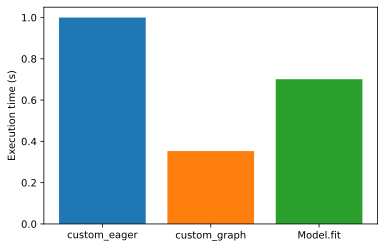

In [58]:
plt.bar(timings.keys(), np.array(list(timings.values())) / max(timings.values()), color=['C0', 'C1', 'C2'])
plt.ylabel('Execution time (s)');

### Regularization

Layers can be configured using optional arguments to choose the type regularization to use.
Regularizers allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes. For Keras, regularization penalties are applied on a per-layer basis. Forward layers such as `Dense` exposes three keyword arguments:

* `kernel_regularizer`: Regularizer to apply a penalty on the layer's kernel
* `bias_regularizer`: Regularizer to apply a penalty on the layer's bias
* `activity_regularizer`: Regularizer to apply a penalty on the layer's output

In [59]:
import tensorflow.keras.regularizers as regularizers
tf.random.set_seed(0)

model = kr.Sequential()
model.add(Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
model.add(Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
model.add(Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
model.add(Dense(units=10))

fit_fmnist_model(model)

Epoch 1/3


2022-07-21 18:02:30.814350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 13s 7ms/step - loss: 1.3974 - sparse_categorical_accuracy: 0.8145 - val_loss: 1.2775 - val_sparse_categorical_accuracy: 0.8415
Epoch 2/3


2022-07-21 18:02:43.312177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 12s 6ms/step - loss: 1.1934 - sparse_categorical_accuracy: 0.8631 - val_loss: 1.1967 - val_sparse_categorical_accuracy: 0.8504
Epoch 3/3
1875/1875 [==============================] - 12s 6ms/step - loss: 1.1046 - sparse_categorical_accuracy: 0.8752 - val_loss: 1.1337 - val_sparse_categorical_accuracy: 0.8563


Here we train the same network as above. You can test by setting the regularization parameter to zero that this reproduces the above results. Since we have different results, this means that the `fit` method automatically takes into account the regularization terms during backpropagation without any further setting.

#### Regularization in training loops

For custom training loops, we have to account for weight regularization before performing backpropagation. This can be implemented by simply adding `sum(self.losses)` to the loss function result.
This, and the L2 regularization on dense layer weights, are the only modifications made in `CustomModel` to define `RegularizedModel` below:

In [60]:
class RegularizedModel(tf.keras.Model):
    def __init__(self, param=0.0):
        super().__init__(self)
        self.h0 = Dense(256, 'relu', kernel_regularizer=regularizers.l2(param))
        self.h1 = Dense(256, 'relu', kernel_regularizer=regularizers.l2(param))
        self.h2 = Dense(256, 'relu', kernel_regularizer=regularizers.l2(param))
        self.h3 = Dense(10)
    
    def call(self, x, training=False):
        return self.h3(self.h2(self.h1(self.h0(x))))

    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            preds = self.call(inputs, training=True)
            loss = self.compiled_loss(targets, preds) + sum(self.losses)  # <-- Final objective
        
        # Update states
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(targets, preds)
        
        # Return logs
        logs = {m.name: m.result() for m in self.metrics}
        return logs

    def test_step(self, data):
        inputs, targets = data
        preds = self.call(inputs, training=False)

        # Update states
        self.compiled_loss(targets, preds)
        self.compiled_metrics.update_state(targets, preds)

        # Return logs
        logs = {m.name: m.result() for m in self.metrics}
        return logs


# Construct and compile an instance of CustomModel
tf.random.set_seed(0)
model = RegularizedModel(param=1e-3)
fit_fmnist_model(model)

Epoch 1/3
   1/1875 [..............................] - ETA: 10:31 - loss: 2.5113 - sparse_categorical_accuracy: 0.0312

2022-07-21 18:03:07.969846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 12s 6ms/step - loss: 0.5252 - sparse_categorical_accuracy: 0.8145 - val_loss: 0.4338 - val_sparse_categorical_accuracy: 0.8415
Epoch 2/3


2022-07-21 18:03:19.192620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 11s 6ms/step - loss: 0.3777 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.4084 - val_sparse_categorical_accuracy: 0.8504
Epoch 3/3
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3424 - sparse_categorical_accuracy: 0.8752 - val_loss: 0.3968 - val_sparse_categorical_accuracy: 0.8563


Notice that the results for the `fit` method are reproduced except for the loss value which corresponds only to the cross entropy. Though including regularization penalty to the total loss in the logs seems to be less useful, if we want to be totally consistent with Keras `fit`, we can use:

```python
loss = self.compiled_loss(targets, preds, regularization_losses=self.losses)
```

**Aside.** 
You might be wondering how you can create additive scalar loss terms from values computed during forward pass. This can be done in custom layers by calling the [`add_loss()`](https://keras.io/api/losses/#the-addloss-api) layer method. These quantities are then accumulated in the `self.losses` attribute.